# Captum Interpretability Test
Here we use the package Captum to test how to best analyse and isolate model components, to compare their performance if trained with or without DP. <br><br>
The tests are strongly based on the [Captum Tutorials](https://captum.ai/tutorials/CIFAR_TorchVision_Interpret)

In [11]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from torchvision import models

from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

from captum.attr import visualization as viz


from scipy import stats
import pandas as pd

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='../../data/', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../../data/', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        self.relu4 = nn.ReLU()

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [4]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [6]:
USE_PRETRAINED_MODEL = True
DEVICE = "cuda:0"
net = net.to(DEVICE)

if USE_PRETRAINED_MODEL:
    print("Using existing trained model")
    net.load_state_dict(torch.load('../../models/cifar_torchvision.pt'))
else:
    for epoch in range(5):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')
    torch.save(net.state_dict(), '../../models/cifar_torchvision.pt')

Using existing trained model


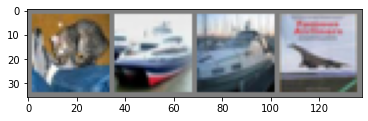

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship plane plane


In [7]:
def imshow(img, transpose = True):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))


outputs = net(images.to(DEVICE))

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [16]:
ind = 3

input = images[ind].unsqueeze(0).to(DEVICE)
input.requires_grad = True

In [17]:
net.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (relu1): ReLU()
  (relu2): ReLU()
  (relu3): ReLU()
  (relu4): ReLU()
)

In [18]:
def attribute_image_features(algorithm, input, **kwargs):
    net.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=labels[ind],
                                              **kwargs
                                             )
    
    return tensor_attributions

In [19]:
saliency = Saliency(net)
grads = saliency.attribute(input, target=labels[ind].item())
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

In [20]:
# More details about integrated gradients can be found in the original paper: https://arxiv.org/abs/1703.01365
ig = IntegratedGradients(net)
attr_ig, delta = attribute_image_features(ig, input, baselines=input * 0, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

Approximation delta:  tensor([0.0274], device='cuda:0', dtype=torch.float64)


In [21]:
ig = IntegratedGradients(net)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(nt, input, baselines=input * 0, nt_type='smoothgrad_sq',
                                      nt_samples=100, stdevs=0.2)
attr_ig_nt = np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

In [22]:
dl = DeepLift(net)
attr_dl = attribute_image_features(dl, input, baselines=input * 0)
attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

/home/nico/anaconda3/envs/dp_mt/lib/python3.8/site-packages/captum/attr/_core/deep_lift.py:322: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


Original Image
Predicted: plane  Probability: 0.7744230628013611


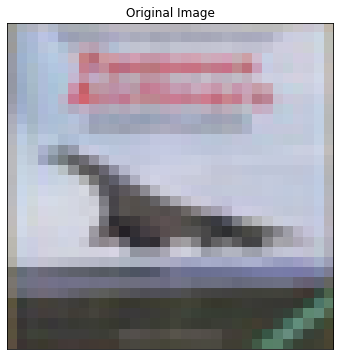

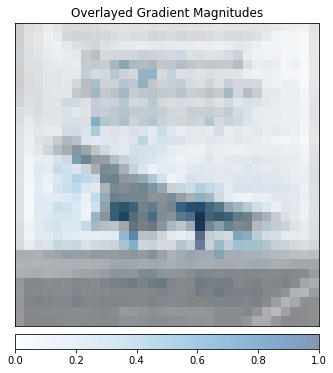

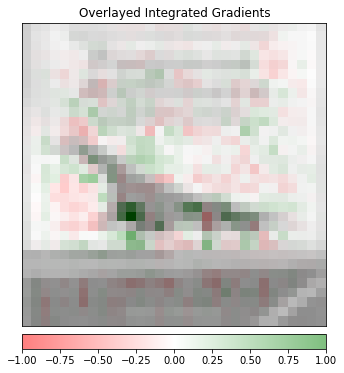

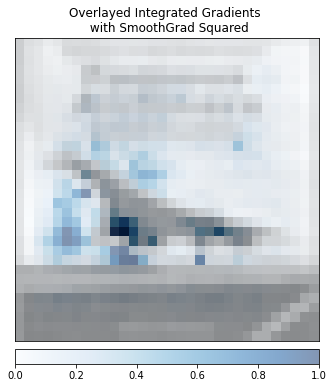

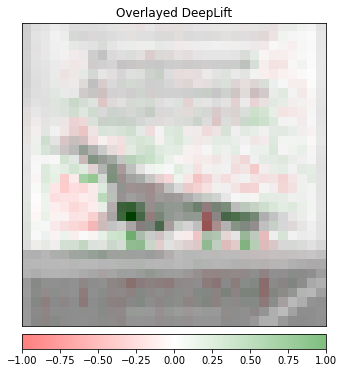

In [23]:
print('Original Image')
print('Predicted:', classes[predicted[ind]], 
      ' Probability:', torch.max(F.softmax(outputs, 1)).item())

original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

_ = viz.visualize_image_attr(None, original_image, 
                      method="original_image", title="Original Image")

_ = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes")

_ = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")

_ = viz.visualize_image_attr(attr_ig_nt, original_image, method="blended_heat_map", sign="absolute_value", 
                             outlier_perc=10, show_colorbar=True, 
                             title="Overlayed Integrated Gradients \n with SmoothGrad Squared")

_ = viz.visualize_image_attr(attr_dl, original_image, method="blended_heat_map",sign="all",show_colorbar=True, 
                          title="Overlayed DeepLift")

# Custom Tests
Try out some custom tests based on the tutorials.

## Layer Attribution - Conductance
To test what neuron in what layer has had what impact on the prediction.

In [8]:
# Helper method to print importances and visualize distribution
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)

In [45]:
# TODO: create batch with multiple different samples (for dist at the end)
dataiter = iter(testloader)
images, labels = dataiter.next()
ind = 3
test_input_tensor = images[ind].unsqueeze(0).to(DEVICE)
test_input_tensor.requires_grad = True

To use Layer Conductance, we create a LayerConductance object passing in the model as well as the module (layer) whose output we would like to understand. In this case, we choose net.sigmoid1, the output of the first hidden layer.

In [46]:
cond = LayerConductance(net, net.relu3)

We can now obtain the conductance values for all the test examples by calling attribute on the LayerConductance object. LayerConductance also requires a target index for networks with mutliple outputs, defining the index of the output for which gradients are computed. Similar to feature attributions, we provide target = 1, corresponding to survival. LayerConductance also utilizes a baseline, but we simply use the default zero baseline as in integrated gradients.

In [47]:
# the current test_input_tensor is a plane which has index 0
cond_vals = cond.attribute(test_input_tensor,target=0)
cond_vals = cond_vals.detach().cpu().numpy()
cond_vals.shape

(1, 120)

We can begin by visualizing the average conductance for each neuron.

Average Neuron Importances
0 :  0.000
1 :  0.000
2 :  0.000
3 :  0.243
4 :  0.000
5 :  0.239
6 :  -0.001
7 :  -0.174
8 :  -0.042
9 :  -0.078
10 :  0.282
11 :  0.557
12 :  0.000
13 :  0.848
14 :  0.000
15 :  0.000
16 :  0.000
17 :  -0.012
18 :  0.078
19 :  0.000
20 :  0.000
21 :  -0.128
22 :  0.012
23 :  0.000
24 :  -0.055
25 :  0.000
26 :  0.000
27 :  -0.076
28 :  0.000
29 :  0.000
30 :  0.006
31 :  0.004
32 :  0.046
33 :  0.000
34 :  0.289
35 :  -0.018
36 :  0.001
37 :  0.021
38 :  0.000
39 :  0.000
40 :  -0.084
41 :  0.543
42 :  -0.000
43 :  -0.018
44 :  0.000
45 :  -0.107
46 :  0.000
47 :  0.028
48 :  -0.123
49 :  0.090
50 :  0.000
51 :  0.000
52 :  0.001
53 :  0.000
54 :  0.000
55 :  0.000
56 :  0.000
57 :  0.000
58 :  -0.025
59 :  -0.011
60 :  0.000
61 :  0.000
62 :  -0.074
63 :  0.000
64 :  0.001
65 :  0.000
66 :  0.000
67 :  0.000
68 :  0.000
69 :  0.000
70 :  0.001
71 :  0.000
72 :  0.000
73 :  -0.080
74 :  0.000
75 :  -0.005
76 :  0.000
77 :  0.001
78 :  0.074
79 :  0.000
80 :

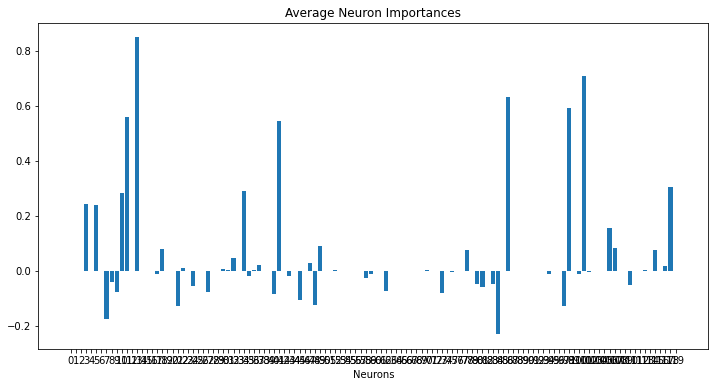

In [48]:
# 120 neurons in that layer
visualize_importances(range(120),np.mean(cond_vals, axis=0),title="Average Neuron Importances", axis_title="Neurons")

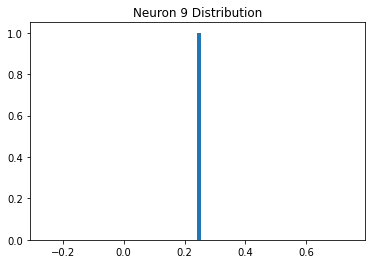

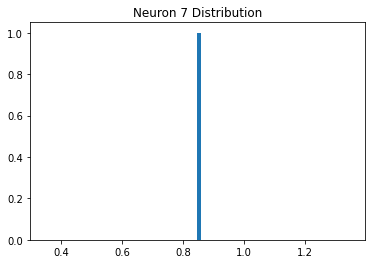

In [49]:
# Neuron 3 and 13
plt.hist(cond_vals[:,3], 100);
plt.title("Neuron 9 Distribution")
plt.figure()
plt.hist(cond_vals[:,13], 100);
plt.title("Neuron 7 Distribution");


## Neuron Attribution 

In [ ]:
# TODO: finish above example with more than one sample to get real distribution 
# probably LIME, etc. however better? Get more into details
# TODO: Check 00_CaptumTut_Titanic_Basic_Interpret.ipynb
# TODO: Add LIME: Simple and visually simple to check whether DP-trained networks 
# looked at other parts (or in a more diffuse manner) than non-DP-trained networks. 